# Breast Cancer Detection based on Histopathology Images

## About the Data:

- **Data Source:** https://www.kaggle.com/code/nasrulhakim86/breast-cancer-histopathology-images-classification/data
- The Breast Cancer Histopathological Image Classification (BreakHis) is composed of 9,109 microscopic images of breast tumor tissue collected from 82 patients.
- The images are collected using different magnifying factors (40X, 100X, 200X, and 400X). 
- To date, it contains 2,480 benign and 5,429 malignant samples (700X460 pixels, 3-channel RGB, 8-bit depth in each channel, PNG format).
- This database has been built in collaboration with the P&D Laboratory – Pathological Anatomy and Cytopathology, Parana, Brazil (http://www.prevencaoediagnose.com.br). 
- Each image filename stores information about the image itself: method of procedure biopsy, tumor class, tumor type, patient identification, and magnification factor. 
- For example, SOBBTA-14-4659-40-001.png is the image 1, at magnification factor 40X, of a benign tumor of type tubular adenoma, original from the slide 14-4659, which was collected by procedure SOB.

In [221]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn
import os
import shutil
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report

In [416]:
#Importing all the necessary libraries for image processing
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, Callback , ModelCheckpoint
from tensorflow.keras.metrics import Accuracy,binary_crossentropy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [452]:
#Loading the text file
fold_df = pd.read_csv("./BreaKHis_v1/Folds.csv")

**Folds.csv**

1. Folds.csv contains all the information about the patient images.
2. Folds.csv consists of the magnifying factor of the image. the exact path where the image is stores.
3. So, We can extract useful information from the filename.
4. Here Folds.csv plays major role in designing the system.

In [453]:
#Defining the paths
img_path = "./BreaKHis_v1/"
classes = ["benign","malign"]

In [454]:
#Renaming the column filename to path
fold_df = fold_df.rename(columns = {"filename":"path"})
#Printing the head of the file
fold_df.head(3)

fold  mag    grp                                               path
0     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
1     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
2     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...

In [355]:
#One example path is printed
fold_df['path'][1]

'BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-002.png'

**Info:**

- From the path column we can extract the exact file name using apply and split functions on the path column.
- And also the class is extracted.

In [358]:
fold_df['filename'] = fold_df['path'].apply(lambda x:x.split("/")[-1])
fold_df["label"] = fold_df['path'].apply(lambda x: x.split("/")[3])

In [359]:
fold_df.head(3)

fold  mag    grp                                               path  \
0     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
1     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
2     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
3     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
4     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   

                         filename   label  
0  SOB_B_A-14-22549AB-100-001.png  benign  
1  SOB_B_A-14-22549AB-100-002.png  benign  
2  SOB_B_A-14-22549AB-100-003.png  benign  
3  SOB_B_A-14-22549AB-100-004.png  benign  
4  SOB_B_A-14-22549AB-100-005.png  benign

**Creating New Directiory Cancer**

- The given data consists of very complex structure of folders where it stores the images.
- The structure as follows:
    - BreaKHis_v1
        - histology_slides
            - breast
                - **benign**
                    - **SOB**
                        - Type
                            - **patient_id**  
                                - 40x
                                - 100x
                                - 200x
                                - 400x
                - **malignant**
                    - **SOB**
                        - Type
                            - **patient_id**   
                                - 40x
                                - 100x
                                - 200x
                                - 400x
- To make things simple, using the exact path of the images, all the images are moved to the common folder called **Cancer.**
- Images are renamed with their class and patient_id.
                

In [384]:
#Checking the len
len(os.listdir("./Cancer/"))

7910

- All the images are now stores in single folder.

In [360]:
#Creating a new data frame with labels and file names stored in single folder
fold_df['file_loc'] = fold_df['label'] + "_" + fold_df['filename']
#Encoding the class to integer
fold_df['class'] = fold_df['label'].apply(lambda x: 0 if x =='benign' else 1)

In [385]:
#Printing the head to display the changed made
fold_df.head(3)

fold  mag    grp                                               path  \
0     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
1     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
2     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   

                         filename   label  \
0  SOB_B_A-14-22549AB-100-001.png  benign   
1  SOB_B_A-14-22549AB-100-002.png  benign   
2  SOB_B_A-14-22549AB-100-003.png  benign   

                                file_loc  class  
0  benign_SOB_B_A-14-22549AB-100-001.png      0  
1  benign_SOB_B_A-14-22549AB-100-002.png      0  
2  benign_SOB_B_A-14-22549AB-100-003.png      0

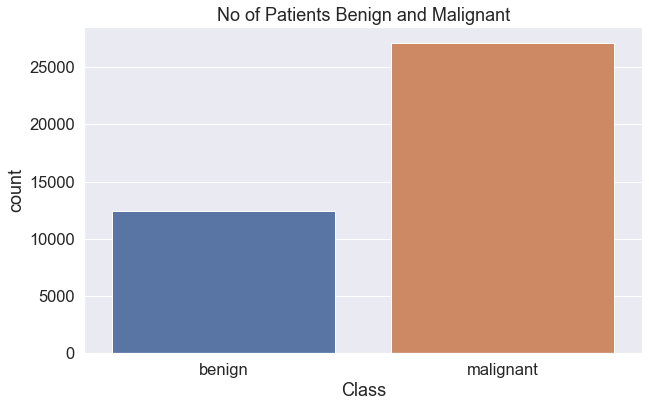

In [372]:
#Lets explore the data set
plt.figure(figsize=(10,6))
sns.set(font_scale = 1.5)
sns.set_style("darkgrid")
sns.countplot(fold_df['label']);
plt.xlabel("Class")
plt.title("No of Patients Benign and Malignant");

- Data is Highly Imabalanced as this is the case with the real world.
- Medical datas are usually imbalanced because of their nature.

In [373]:
#Filtering the data frame to benign and malignant for visualization
benign_df = fold_df[fold_df['label'] == 'benign']
malignant_df = fold_df[fold_df['label'] == 'malignant']

# Benign Samples

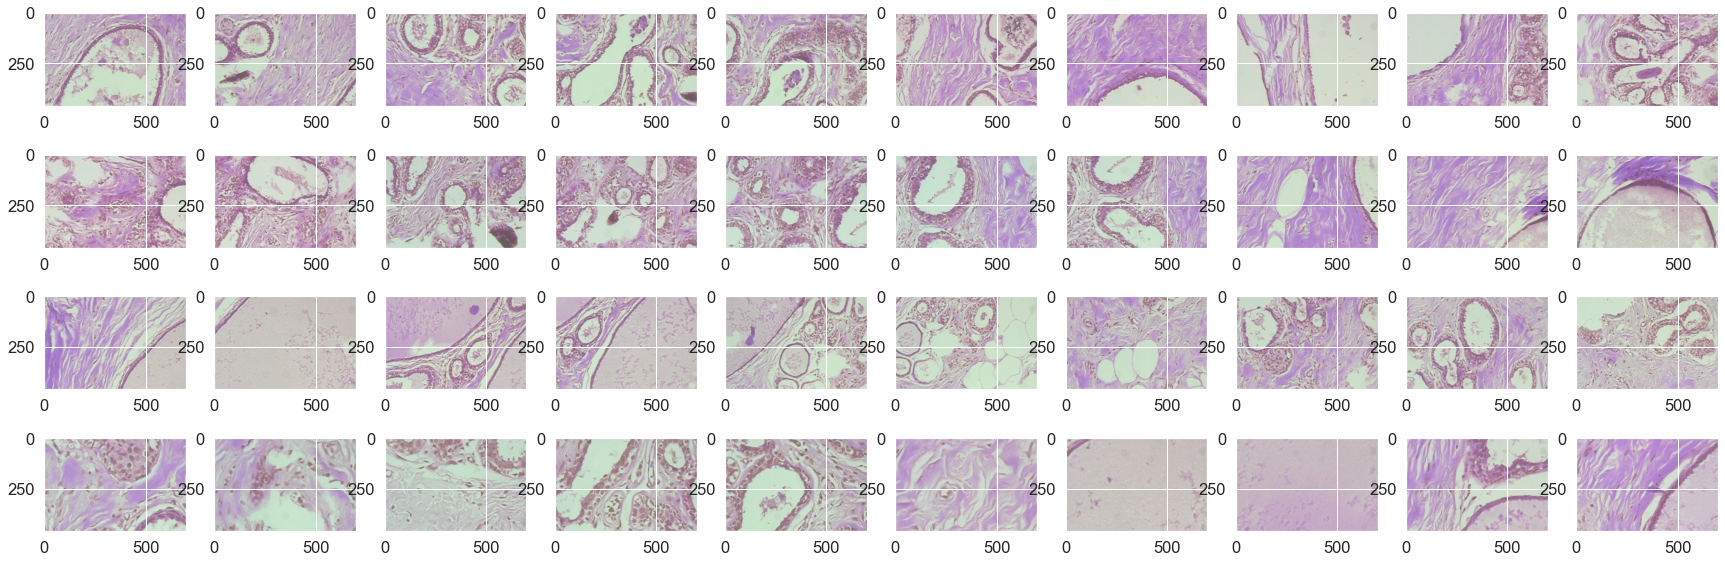

In [378]:
#Plotting the benign samples
plt.figure(figsize = (30,10))
for i in range(0,40):
    plt.subplot(4,10,i+1)
    img = cv2.imread("./Cancer/"+benign_df['file_loc'][i],1)
    plt.imshow(img)

# Malignant Samples

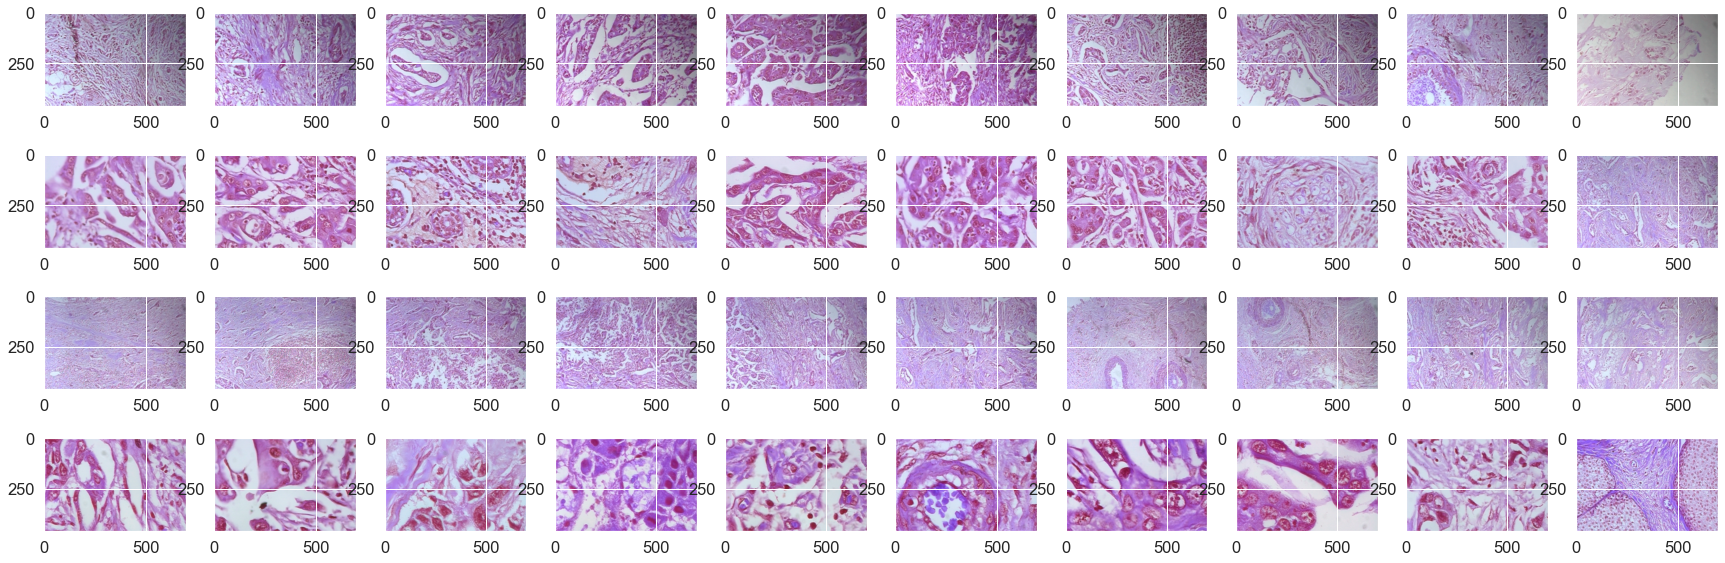

In [375]:
#Plotting the malignant samples
images = malignant_df['file_loc'].values
plt.figure(figsize = (30,10))
for i in range(0,40):
    plt.subplot(4,10,i+1)
    img = cv2.imread("./Cancer/"+ images[i],1)
    plt.imshow(img)

**Findings:**

- From the above images there is very little to no difference between malignant and benign samples.
- This might be because we are not the pathologists, That's the original purpose of the detection system.
- Thus it makes it easy in the absence of actual pathologists.

In [390]:
#Creating a new data frame with the file loc as its index, label and class of the patients as its columns.
df = pd.DataFrame(os.listdir("./Cancer/"))
df = df.rename(columns = {0:'file_loc'})
df['label'] = df['file_loc'].apply(lambda x:x.split("_")[0])
df['class'] = df['label'].apply(lambda x: 0 if x =='benign' else 1)
df.set_index("file_loc",inplace=True)

In [391]:
#Checking the data frame
df.head(2)

label  class
file_loc                                                 
malignant_SOB_M_MC-14-19979-100-013.png  malignant      1
benign_SOB_B_F-14-23060CD-40-008.png        benign      0

- Using the data frame, the splitting for train, test and validation is done.
- 10% is kept aside as the test data, and 10% as validation data.
- 80% is taken as the training data.

In [394]:
#Performing the splitting
data_train_and_val, data_test = train_test_split(df, test_size = 0.1, random_state = 47)
#Traing and val
data_train, data_val = train_test_split(data_train_and_val, test_size = 0.1, random_state = 47)

In [395]:
print("Training size :", data_train.shape)
print("Validation size :", data_val.shape)
print("Testing size :", data_test.shape)

Training size : (6407, 2)
Validation size : (712, 2)
Testing size : (791, 2)


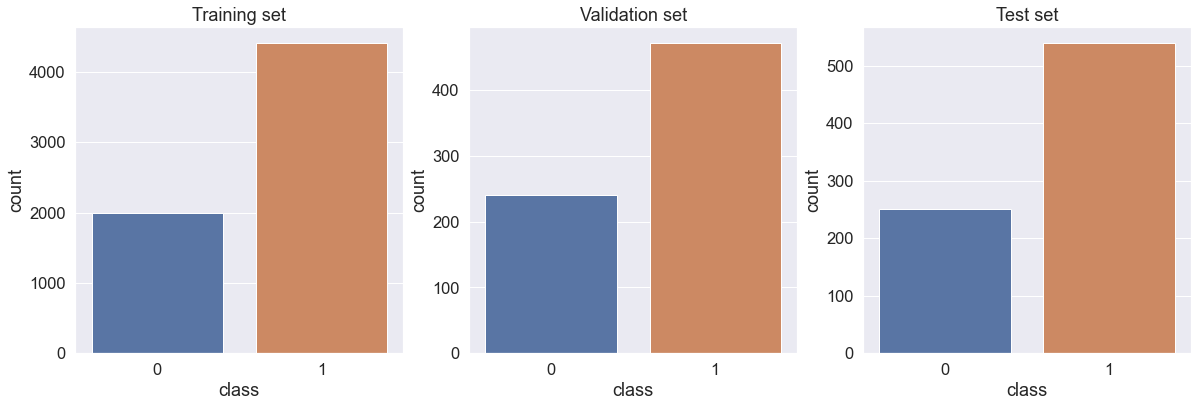

In [396]:
#Plotting
sns.set_style("darkgrid")
plt.figure(figsize = (20,6))
plt.subplot(1,3,1)
sns.countplot(data_train['class'])
plt.title("Training set")
plt.subplot(1,3,2)
sns.countplot(data_val['class'])
plt.title("Validation set")
plt.subplot(1,3,3)
sns.countplot(data_test['class']);
plt.title("Test set");

- Training , Validation and Testing data is pretty imbalanced as this is the case in the real world.
- Here the validation and testing set is left as it is, because it should reflects the real world scenario.
- And the training data is balanced by oversampling the minority class(Benign).

In [397]:
#Separating the benign and malignant patients from train data
train_has_cancer = data_train[data_train['class'] == 1]
train_has_no_cancer = data_train[data_train['class'] == 0]

In [398]:
train_has_cancer.shape

(4418, 2)

In [399]:
train_has_no_cancer.shape

(1989, 2)

In [401]:
#Upsampling the minority class by the size of majority class with replacement
train_has_no_cancer_upsample = resample(train_has_no_cancer, n_samples = len(train_has_cancer), 
                                     random_state = 47, replace = True)

In [402]:
#Concatenating the upsampled minority class and the majority class
data_train = pd.concat([train_has_cancer,train_has_no_cancer_upsample])

- As expected the training data is balanced.

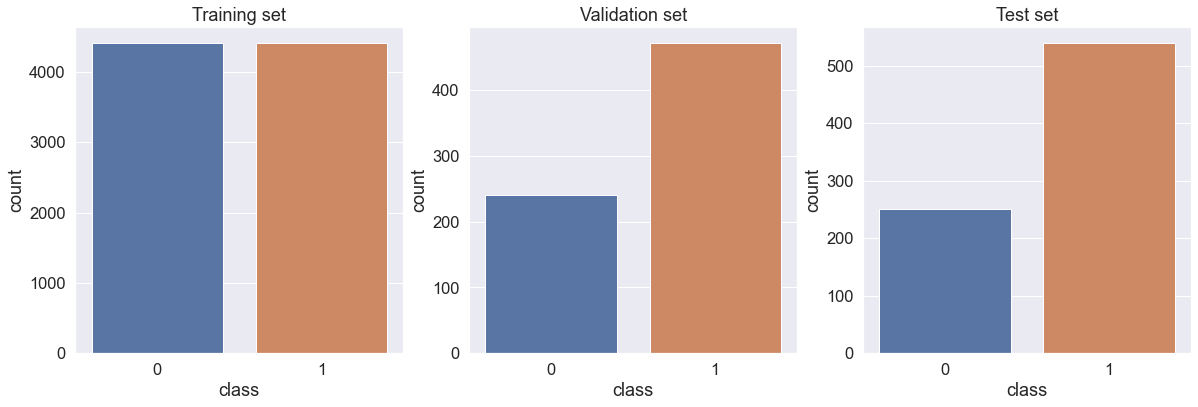

In [404]:
sns.set_style("darkgrid")
plt.figure(figsize = (20,6))
plt.subplot(1,3,1)
sns.countplot(data_train['class'])
plt.title("Training set")
plt.subplot(1,3,2)
sns.countplot(data_val['class'])
plt.title("Validation set")
plt.subplot(1,3,3)
sns.countplot(data_test['class']);
plt.title("Test set");

## Creating the directory structure for Training , Validation and Testing:

- Earlier all the images where stored in the single directory called Cancer.
- Now we are using Image data generator as part of our algorithm designing.
- Image data generator expects the Images to be in the following structure:
    - **Train**
        - Benign
        - Malignant
    - **Validation**
        - Benign
        - Malignant
    - **Testing**
        - Benign
        - Malignant
- Above structure is the prerequisite for the Image Data Generator to run.
        

- Using the above directories and the splitted data frames data_train, data_val, data_test.
- We are moving the images to the corresponding directories based on the class of the image(Benign or Malignant).

In [415]:
#Checking their lengths
print("Training Data:")
print(" ")
print("Benign:",len(os.listdir("./Cancer_train/benign/")))
print("Malignant::",len(os.listdir("./Cancer_train/malignant/")))
print(" ")
print("Validation Data")
print(" ")
print("Benign size:",len(os.listdir("./Cancer_validation/benign/")))
print("Malignant size :",len(os.listdir("./Cancer_validation/malignant/")))
print(" ")
print("Testing Data:")
print(" ")
print("Benign size :",len(os.listdir("./Cancer_test/benign/")))
print("Malignant size :",len(os.listdir("./Cancer_test/malignant/")))

Training Data:
 
Benign: 4418
Malignant:: 4417
 
Validation Data
 
Benign size: 240
Malignant size : 472
 
Testing Data:
 
Benign size : 251
Malignant size : 540


- Training data is balanced.
- Testing and Validation data is kept as such to reflect the real scenario.

## Image Data Generator

- Reference:  https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
- Generates batches of tensor image data with real-time data augmentation.
- Thus CNN sees new set of images with different variation at each epoch.
- One of the useful methods to prevent the model from Overfitting.

In [252]:
#Defining Image Data Generator
datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,
    shear_range=0.2,
    fill_mode='nearest',
    zoom_range=0.2)

- Here the **Image Data Generator** is defined with following functions:
    - Random rotation by 20 degrees.
    - Horizontal flip.
    - Vertical flip.
    - Rescale image by its pixel value.
    - Randomly Zoom image by 20%.
    - Random shear by 20%.

**Flow from Directory**
- Earlier Image folders where created as per the prerequisite.
- Here the flow_from_directory will find the number of images and their classes based on the hierarchy.
- Size of the image is set to 128x128.
- Batch size of 32 and class mode of binary(Benign or Malignant).

In [253]:
#Setting up the images for image data generator
train_generation = datagen.flow_from_directory("Cancer_train/",target_size=(128,128),batch_size = 32, class_mode="binary")
val_generation = datagen.flow_from_directory("Cancer_validation/", target_size=(128,128), batch_size=32, class_mode="binary")

Found 8835 images belonging to 2 classes.
Found 712 images belonging to 2 classes.


# CNN Architecture 

- CNN architecture is defined using **Conv2D layers and Maxpooling layers.**
- Dropout Layers are added to randomly turn off some neurons while training to prevent from overfitting.
- Flatten layer is added at the end to form Dense Layers.
- **relu** is used as activation in all the layers and **Sigmoid** as the activation in the output layer.

In [254]:
#Defining the base model
cancer_model = Sequential()

#First Layer
cancer_model.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape = (128,128,3), activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))

#Second Layer
cancer_model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same',activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))

#Third Layer
cancer_model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))
cancer_model.add(Dropout(0.4))

#Fourth Layer
cancer_model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))
cancer_model.add(Dropout(0.2))

#Flattening the layers
cancer_model.add(Flatten())

#Adding the dense layer
cancer_model.add(Dense(256, activation = 'relu'))
cancer_model.add(Dense(128, activation = 'relu'))
cancer_model.add(Dense(1, activation = 'sigmoid'))

cancer_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 63, 63, 64)        18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 31, 31, 128)       73856     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 15, 15, 128)       0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 15, 15, 128)      

In [255]:
#Setting the learning rate to reduce gradually over the training period
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=steps*50,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

## **Model Compilation**

- Model is compiled by using binary crossentropy as the loss function and adam optimizer to optimize the weights.
- Early stopping is involved to monitor validation loss inorder to prevent overfitting with patience level = 5
- Modelcheckpoint is used to store the best models for every epoch.

In [256]:
#Compiling the model
cancer_model.compile(loss='binary_crossentropy', optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint("./Best_model/",save_best_only=True,)

## Model Fit 

- Model is fitted using train and validation generators generated using Image DataGenerator.
- Verbose is set to 1 to monitor accuracy and losses.
- Model is trained for 200 epochs.
- early stopping and checkpoint are used as the call backs.

In [257]:
#Model is fitted using train and validation generator for 200 epochs
history = cancer_model.fit(train_generation, validation_data=val_generation, epochs=200 ,
                 callbacks=[early_stop,checkpoint], verbose = 1)

Epoch 1/200
277/277 [==============================] - 155s 558ms/step - loss: 0.5947 - accuracy: 0.6747 - val_loss: 0.4924 - val_accuracy: 0.7865
Epoch 2/200
277/277 [==============================] - 148s 534ms/step - loss: 0.5058 - accuracy: 0.7736 - val_loss: 0.4774 - val_accuracy: 0.8216
Epoch 3/200
277/277 [==============================] - 145s 524ms/step - loss: 0.4694 - accuracy: 0.7999 - val_loss: 0.4482 - val_accuracy: 0.8216
Epoch 4/200
277/277 [==============================] - 149s 537ms/step - loss: 0.4764 - accuracy: 0.7924 - val_loss: 0.4876 - val_accuracy: 0.7963
Epoch 5/200
277/277 [==============================] - 141s 509ms/step - loss: 0.4623 - accuracy: 0.8011 - val_loss: 0.5799 - val_accuracy: 0.6882
Epoch 6/200
277/277 [==============================] - 141s 510ms/step - loss: 0.4300 - accuracy: 0.8174 - val_loss: 0.3917 - val_accuracy: 0.8624
Epoch 7/200
277/277 [==============================] - 140s 507ms/step - loss: 0.4287 - accuracy: 0.8183 - val_loss: 0

Epoch 41/200
277/277 [==============================] - 141s 509ms/step - loss: 0.1994 - accuracy: 0.9212 - val_loss: 0.2409 - val_accuracy: 0.9073
Epoch 42/200
277/277 [==============================] - 140s 505ms/step - loss: 0.2004 - accuracy: 0.9195 - val_loss: 0.2544 - val_accuracy: 0.9059
Epoch 43/200
277/277 [==============================] - 140s 504ms/step - loss: 0.2074 - accuracy: 0.9142 - val_loss: 0.2410 - val_accuracy: 0.9017
Epoch 44/200
277/277 [==============================] - 143s 515ms/step - loss: 0.1861 - accuracy: 0.9236 - val_loss: 0.2004 - val_accuracy: 0.9199
Epoch 45/200
277/277 [==============================] - 141s 509ms/step - loss: 0.1990 - accuracy: 0.9177 - val_loss: 0.2061 - val_accuracy: 0.9115
Epoch 46/200
277/277 [==============================] - 143s 516ms/step - loss: 0.1935 - accuracy: 0.9225 - val_loss: 0.2076 - val_accuracy: 0.9129
Epoch 47/200
277/277 [==============================] - 140s 504ms/step - loss: 0.1713 - accuracy: 0.9295 - val_

## Model Results 

- The model is terminated after 49 epochs as it started overfitting.
- The model is terminated by Early stopping.
- The results are promising as the training accuracy is 93% while validation accuracy is 91.8%.

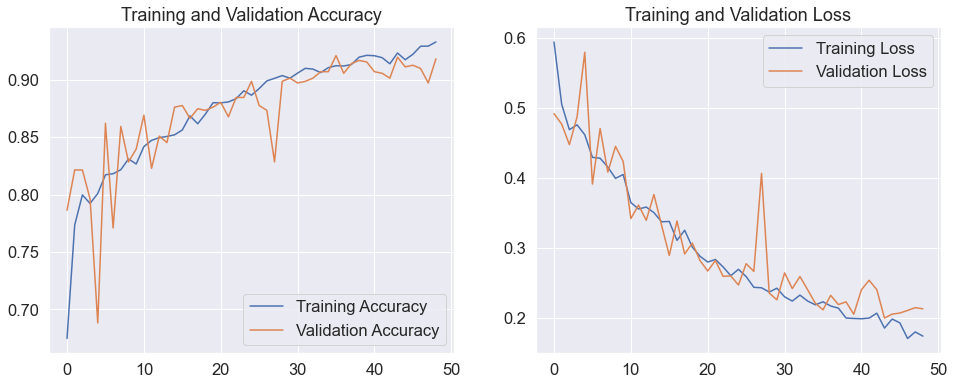

In [420]:
#Plotting the model results

#Getting the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#Getting the losses
loss = history.history['loss']
val_loss = history.history['val_loss']

#No of epochs it trained
epochs_range = history.epoch

#Plotting Training and Validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Evaluation on Test Data 

In [421]:
#Loading the test data using Image Data Generator
test_gen = datagen.flow_from_directory("./Cancer_test/", target_size=(128,128), class_mode="binary", batch_size=1, shuffle=False)

Found 790 images belonging to 2 classes.


In [422]:
pred = cancer_model.evaluate(test_gen)

790/790 [==============================] - 13s 16ms/step - loss: 0.2155 - accuracy: 0.9152


- **Our CNN model is 91.5% accurate in predicting the cancer using the histopathology Images.**

In [428]:
#Let's Go ahead and test our model for few Images.

#Array to hold Input Images and their labels
test = []
labels = []

#Loading random 10 images
random_images = np.random.choice(data_test.index,10)

#For loop to read and store images
for i in random_images:
    #Finding their class to load from folder
    label = data_test.loc[i,"class"]
    labels.append(label)
    if label == 1:
        lab = "malignant"
    else:
        lab = "benign"
    #Creating path
    path = os.path.join("./Cancer_test/", lab, i)
    #reading image
    img = cv2.imread(path)
    #resizing to target shape
    img = cv2.resize(img,(128,128))
    #Making it an numpy array
    img = np.array(img)
    #Appending it to the list
    test.append(img)

#Making the list as numpy array
test = np.asarray(test)
#rescaling it by pixel value
test = test/255.   

In [432]:
#Performing the prediction
pred = (cancer_model.predict(test) > 0.5).astype("int32")
#Flattening the list to form single dimensional list
pred = pred.flatten()

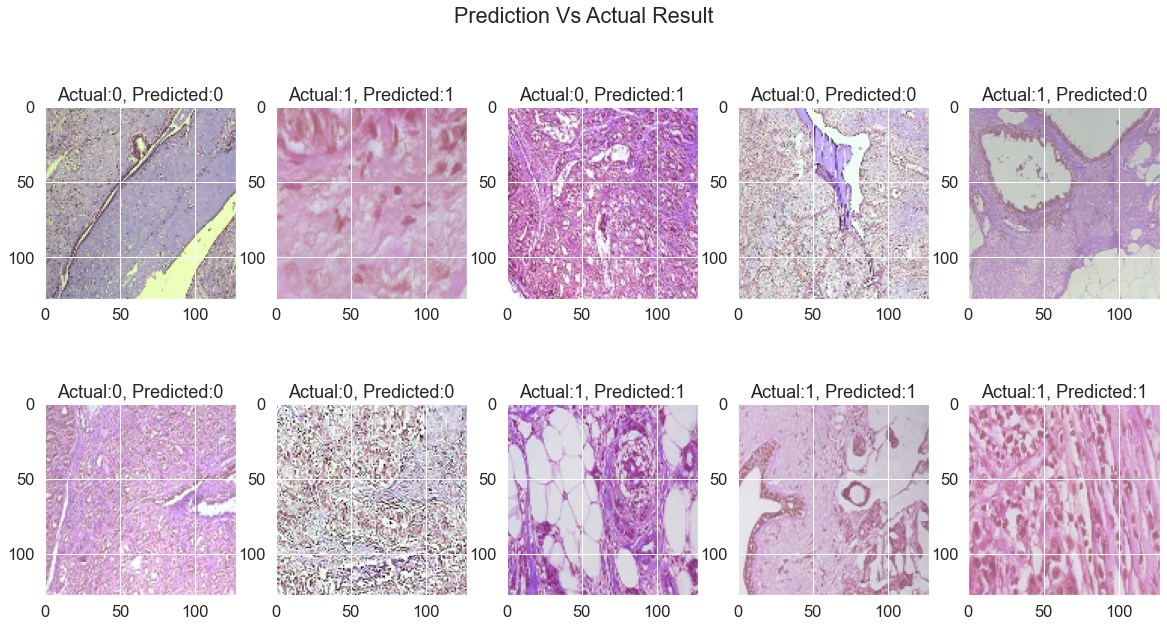

In [449]:
#Plotting results and actual prediction
plt.figure(figsize=(20,10))
plt.suptitle("Prediction Vs Actual Result")
for i in range(0,10):
    string = "Actual:" + str(labels[i]) + ", Predicted:" + str(pred[i])
    plt.subplot(2,5,i+1)
    plt.imshow(test[i])
    plt.title(string)

In [ ]:
#Saving the model for UI Integration
cancer_model.save_weights("Best_model.h5")
cancer_model.save("Final_model.h5")

# Thank You!!